In [1]:
import pandas as pd
import numpy as np

import shap

from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

import operator 

import glob, os, sys

%matplotlib inline
%config Completer.use_jedi = False
pd.set_option('display.max_colwidth', 100)

In [2]:
def modeling(inputfiles, remove_variables = []) :
    
    rmses = []
    r2s = []
    for i, ifile in enumerate(inputfiles) :
        #print(ifile)
        df = pd.read_csv(ifile, low_memory=False)
        df = df.drop(columns=remove_variables)
        columns2log= ['Tnl_ind', 'Tnl_anhe', 'Tnl_reperfusion', 'TnI_pod1']
        for j, col in enumerate(columns2log) :
            df[col] = df[col].apply(np.log)

        y = np.array(df.loc[:,'TnI_pod1'])
        df = df.drop(columns = ['TnI_pod1'])
        features = df.loc[:,'Age':'op_yr'].columns
        X = np.array(df)
        nsplits = 5
        seeds = [13111]
        for j in range(len(seeds)) :

            # splitting data
            x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1543)

            # 1. Bayesian Ridge regression 
            br = BayesianRidge(compute_score=True)
            br.fit(x_train, y_train)
            br_coefs = br.coef_
            if i == 0 :
                br_coefs_df = pd.DataFrame({'Variables':features, 
                                            'Coefs'+str(i+1):br_coefs}).set_index('Variables')
            else :
                tmp = pd.DataFrame({'Variables':features, 
                                    'Coefs'+str(i+1):br_coefs}).set_index('Variables')
                br_coefs_df = pd.merge(br_coefs_df, tmp, how='inner', 
                                       left_index=True, right_index=True)

            y_mean_br, y_std_br = br.predict(x_test, return_std=True)
            score_br = br.score(x_test, y_test)


            # 2. Ridge regression
            rdg = Ridge()
            rdg.fit(x_train, y_train)
            y_mean_rdg = rdg.predict(x_test)
            score_rdg = rdg.score(x_test, y_test)
            rdg_coefs = rdg.coef_
            if i == 0 :
                rdg_coefs_df = pd.DataFrame({'Variables':features, 
                                            'Coefs'+str(i+1):rdg_coefs}).set_index('Variables')
            else :
                tmp = pd.DataFrame({'Variables':features, 
                                    'Coefs'+str(i+1):rdg_coefs}).set_index('Variables')
                rdg_coefs_df = pd.merge(rdg_coefs_df, tmp, how='inner', 
                                       left_index=True, right_index=True)

            # 3. Voting regression
            vr = VotingRegressor([('BayesianRidge', br), ('Ridge', rdg)], 
                                weights=[2, 1])
            vr.fit(x_train, y_train)
            y_mean_vr = vr.predict(x_test)
            score_vr = vr.score(x_test, y_test)

            # saving scores
            r2s.append(score_vr)
            rmses.append(mean_squared_error(y_test, y_mean_vr)**2)

            results = permutation_importance(vr, x_train, y_train, scoring='explained_variance',
                                             n_repeats=1, random_state=1543)
            importance = results.importances_mean
            # summarize feature importance

            fid = {} #feature_important_dict
            for k,v in enumerate(importance):
                fid[features[k]] = v
            sorted_fid = dict(sorted(fid.items(), key=operator.itemgetter(1),reverse=True))
            if i == 0 :
                fid_df = pd.DataFrame.from_records([sorted_fid])
                fid_df = fid_df.T.rename(columns={0:'fi'+str(i+1)})
            else :
                tmp = pd.DataFrame.from_records([sorted_fid])
                tmp = tmp.T.rename(columns={0:'fi'+str(i+1)})
                fid_df = pd.merge(fid_df, tmp, how='inner', left_index=True, right_index=True)

    return rmses, r2s, fid_df, br_coefs_df, rdg_coefs_df

In [3]:
def features_plots(fi, coefs_br, coefs_rdg) : 
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 11.4), sharex=True)
    fi['mean'] = fi.sum(axis=1)/30
    top15_fi = fi.sort_values(by='mean', ascending=False).head(15)
    fi_transposed = top15_fi.drop(columns=['mean']).T
    fi_transposed.columns
    df_features= pd.melt(fi_transposed,var_name='feature name', value_name='feature importance')
    sns.boxplot(x="feature name", y="feature importance", data=df_features, ax=ax[0])
    ax[0].set_title("Top15 Feature importances", fontsize=18)

    for tick in ax[0].get_xticklabels():
        tick.set_rotation(45)
        tick.set_size(15)
        
    ax[0].set_xlabel(None)
    ax[0].set_ylabel('Feature importance', fontsize=15)
    ax[0].tick_params(axis='y', labelsize=15)
    ax[0].minorticks_on()

    coefs_br_transposed = coefs_br.T
    coefs_feature_br = pd.melt(coefs_br_transposed[fi_transposed.columns],var_name='feature name', value_name='coefs')
    sns.boxplot(x="feature name", y="coefs", data=coefs_feature_br, ax=ax[1])
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(45)
        tick.set_size(15)
    ax[1].axhline(0, color='k', linestyle='-.', linewidth=1)
    ax[1].set_xlabel(None)    
    ax[1].set_ylabel('Bayesian ridge coeffients', fontsize=15)
    ax[1].tick_params(axis='y', labelsize=15)
    ax[1].minorticks_on()

    coefs_rdg_transposed = coefs_rdg.T
    coefs_feature_rdg = pd.melt(coefs_rdg_transposed[fi_transposed.columns],var_name='feature name', value_name='coefs')
    sns.boxplot(x="feature name", y="coefs", data=coefs_feature_rdg, ax=ax[2])
    ax[2].axhline(0, color='k', linestyle='-.', linewidth=1)
    for tick in ax[2].get_xticklabels():
        tick.set_rotation(45)
        tick.set_size(15)
    ax[2].set_xlabel(None)
    ax[2].tick_params(axis='y', labelsize=15)
    ax[2].set_ylabel('Ridge regression coeffients', fontsize=15)
    ax[2].minorticks_on()
    plt.tight_layout()

#### 초기 모델 학습

In [4]:
files = glob.glob("imputed_data/*.csv")
files.sort()
RMSEs, R2s, fi, coefs_br, coefs_rdg = modeling(files)

In [5]:
print('RMSE:', np.mean(RMSEs), ', R2:', np.mean(R2s))

RMSE: 0.26888980134911905 , R2: 0.5304961874397204


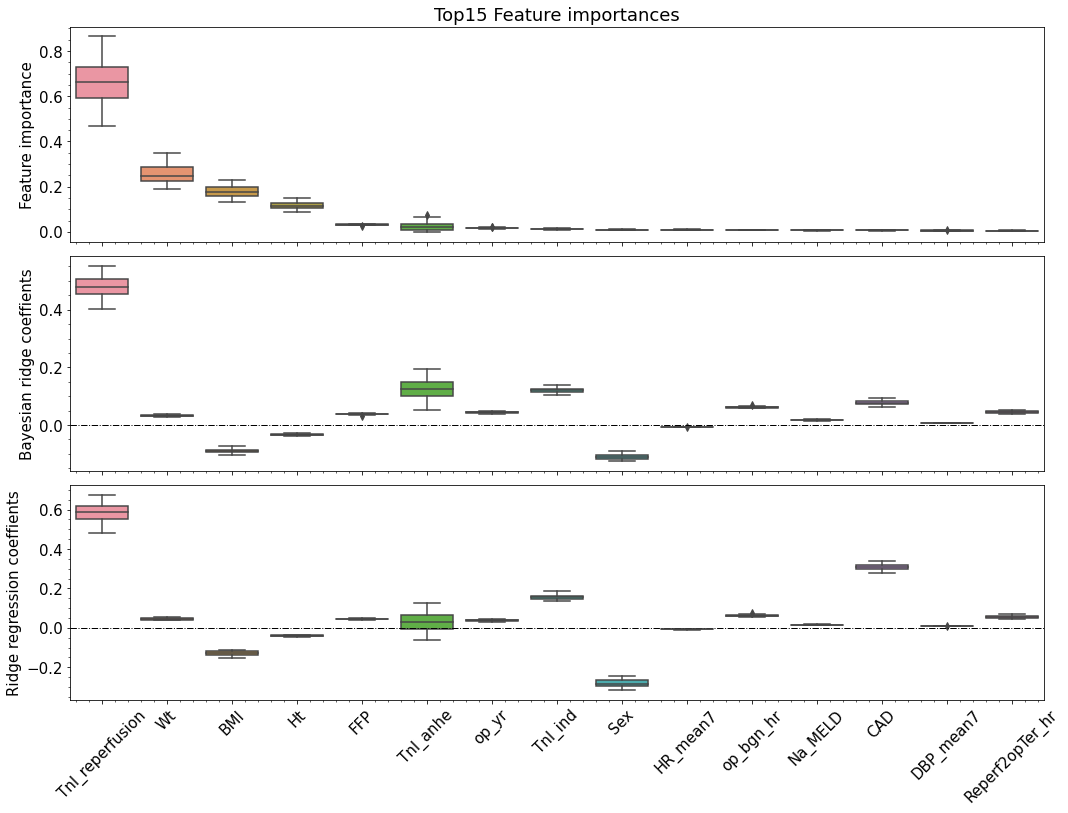

In [6]:
features_plots(fi, coefs_br, coefs_rdg)

#### Feature importance가 음수가 되는 변수들은 모델 안에서 다른 변수들과 상호작용을 하는 것으로 알려져 있고 따라서 이를 찾아서 모델에서 제거

In [7]:
removing_variables = fi[fi['mean']<0].index.values

In [8]:
RMSEs, R2s, fi, coefs_br, coefs_rdg = modeling(files, remove_variables=removing_variables)

In [9]:
print('RMSE:', np.mean(RMSEs), ', R2:', np.mean(R2s))

RMSE: 0.27068020585643354 , R2: 0.528940337634474


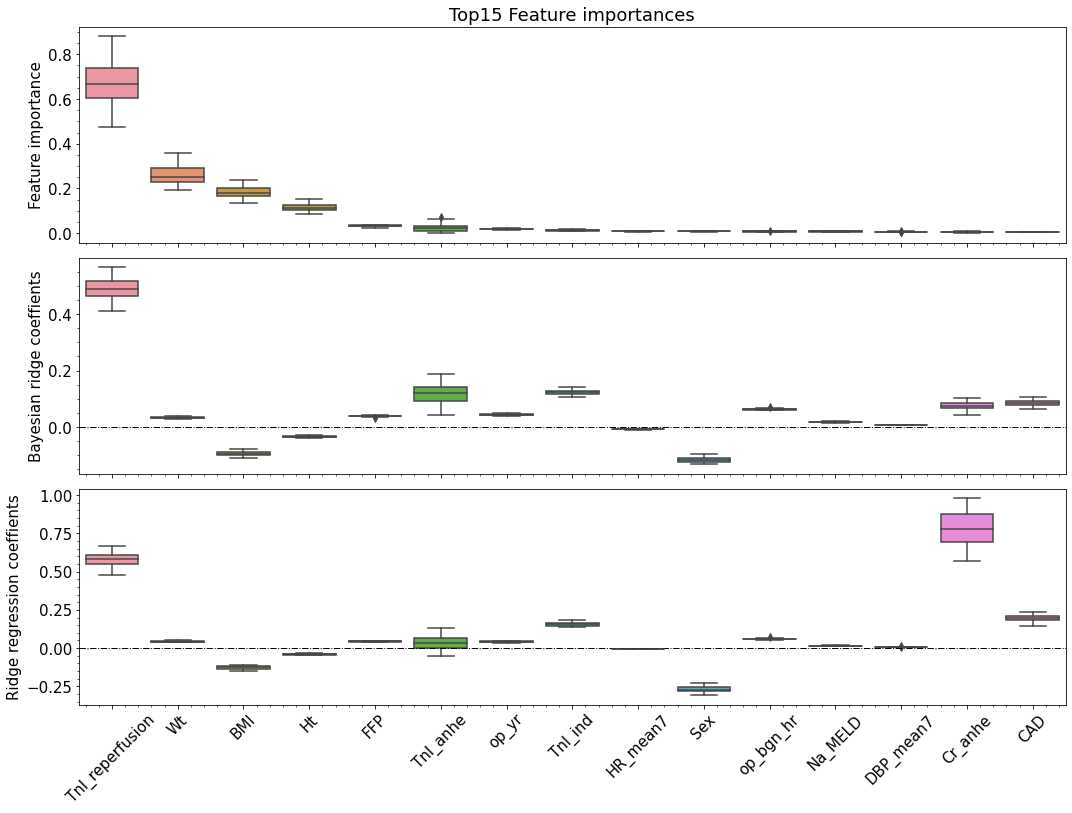

In [10]:
features_plots(fi, coefs_br, coefs_rdg)

In [11]:
#%config InlineBackend.figure_format = 'retina'

<AxesSubplot:>

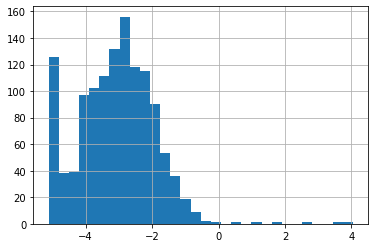

In [35]:
df = pd.read_csv('imputed_data/troponin_pod1_regression_imputed_data01.csv', low_memory=False)
df['log_TnI_pod1'] = df['TnI_pod1'].apply(np.log)
df['log_TnI_pod1'].hist(bins=30)

In [110]:
df = pd.read_csv('imputed_data/troponin_pod1_regression_imputed_data01.csv', low_memory=False)
columns2log= ['Tnl_ind', 'Tnl_anhe', 'Tnl_reperfusion', 'TnI_pod1']
for j, col in enumerate(columns2log) :
    df[col] = df[col].apply(np.log)
y = df['TnI_pod1'].values
df = df.drop(columns = ['TnI_pod1'])
features = df.loc[:,'Age':'op_yr'].columns
# features = ['Tnl_reperfusion', 'BMI', 'Tnl_anhe', 'FFP', 'op_yr', 'Tnl_ind', 
#             'Sex', 'op_bgn_hr', 'Na_MELD', 'HR_mean7', 'DBP_mean7','Cr_anhe']
#X = np.array(df)
seed = 1531
# splitting data
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=seed)

# 1. Bayesian Ridge regression 
br = BayesianRidge(compute_score=True, normalize=True)
br.fit(x_train, y_train)
br_coefs = br.coef_
y_mean_br, y_std_br = br.predict(x_test, return_std=True)
score_br = br.score(x_test, y_test)
score_br_train = br.score(x_train, y_train)
rmse_br = np.sqrt(np.sum((y_test - y_mean_br)**2)/len(y_test))
# 2. Ridge regression
rdg = Ridge(random_state=seed, normalize=True)
rdg.fit(x_train, y_train)
y_mean_rdg = rdg.predict(x_test)
score_rdg = rdg.score(x_test, y_test)
score_rdg_train = rdg.score(x_train, y_train)
rdg_coefs = rdg.coef_
rmse_rdg = np.sqrt(np.sum((y_test - y_mean_rdg)**2)/len(y_test))

# 3. Voting regression
vr = VotingRegressor([('BayesianRidge', br), ('Ridge', rdg)], 
                    weights=[2, 1])
vr.fit(x_train, y_train)
y_mean_vr = vr.predict(x_test)
score_vr = vr.score(x_test, y_test)
score_vr_train = vr.score(x_train, y_train)
rmse_vr = np.sqrt(np.sum((y_test - y_mean_vr)**2)/len(y_test))
    
results = permutation_importance(vr, x_train, y_train, scoring='explained_variance',
                             n_repeats=10, random_state=1543)
importance = results.importances_mean

fid = {} #feature_important_dict
for k,v in enumerate(importance):
    fid[features[k]] = v
sorted_fid = dict(sorted(fid.items(), key=operator.itemgetter(1),reverse=True))
fi_df = pd.DataFrame.from_records([sorted_fid])

In [111]:
print('Bayesian ridge Test-set R^2=', score_br)
print('Ridge regression Test-set R^2=', score_rdg)
print('Voting regressor Test-set R^2=', score_vr)
print('Bayesian ridge Train-set R^2=', score_br_train)
print('Ridge regression Train-set R^2=', score_rdg_train)
print('Voting regressor Train-set R^2=', score_vr_train)

print('Bayesian ridge RMSE=', rmse_br)
print('Ridge regression RMSE=', rmse_rdg)
print('Voting regressor RMSE=', rmse_vr)

Bayesian ridge Test-set R^2= 0.6651056108023397
Ridge regression Test-set R^2= 0.5839174028132462
Voting regressor Test-set R^2= 0.6516186872143446
Bayesian ridge Train-set R^2= 0.6091220738794454
Ridge regression Train-set R^2= 0.5228499513713691
Voting regressor Train-set R^2= 0.5929046443387047
Bayesian ridge RMSE= 0.6910878567240945
Ridge regression RMSE= 0.7703163254403633
Voting regressor RMSE= 0.7048663075556716


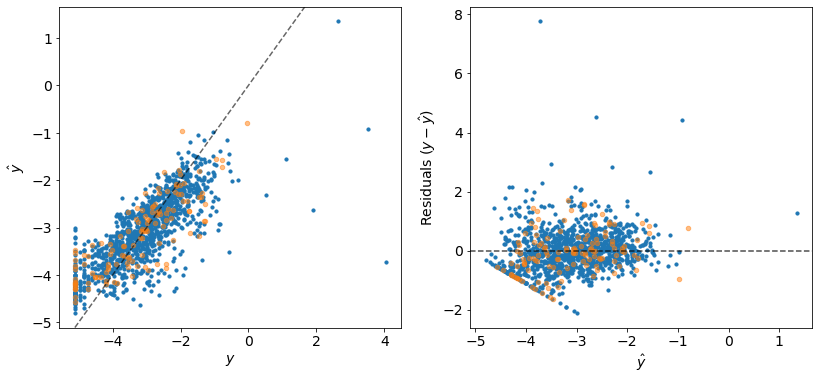

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(13.5, 5.9))
ax[0].scatter(y_train, vr.predict(x_train), s=10, color='tab:blue')
ax[0].scatter(y_test, y_mean_vr, s=20, color='tab:orange', alpha=0.5)
ax[0].axline([0, 0], [1, 1], ls='--', color='k', alpha=0.6)
ax[0].set_xlabel('$y$', fontsize=14)
ax[0].set_ylabel('$\hat{y}$', fontsize=14)
ax[0].tick_params(axis='both', labelsize=14)
#ax[0].set_xlim([0, 0.7])
#ax[0].set_ylim([0, 0.4])
#ax[0].plot([ax[0].get_xlim()[0],ax[0].get_xlim()[1]], 
#           [ax[0].get_ylim()[0],ax[0].get_ylim()[1]], 'k--')
ax[1].scatter(vr.predict(x_train), y_train-vr.predict(x_train), s=10, color='tab:blue' )
ax[1].scatter(y_mean_vr, y_test-y_mean_vr, s=20, color='tab:orange', alpha=0.5)
ax[1].set_xlabel('$\hat{y}$', fontsize=14)
ax[1].set_ylabel('Residuals ($y-\hat{y}$)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=14)
ax[1].axline([0, 0], [1, 0], color='k', linestyle='--', alpha=0.7)
#ax[1].set_xlim([0., 0.5])
#ax[1].set_ylim([-0.2, 0.4])

In [107]:
fi_transposed = fi_df.T
fi_transposed.columns=['features_importance']
top10_columns = fi_transposed.head(10).index

In [115]:
explainer = shap.LinearExplainer(br, df)
shap_values = explainer.shap_values(df)

In [121]:
explainer.expected_value

-3.0820387936159577

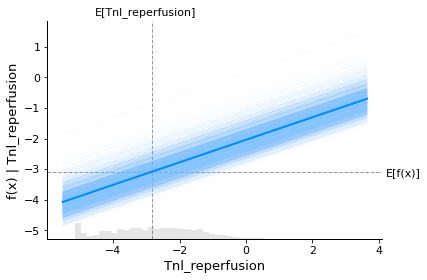

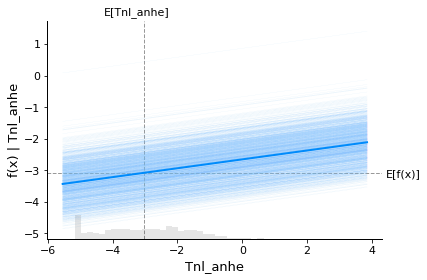

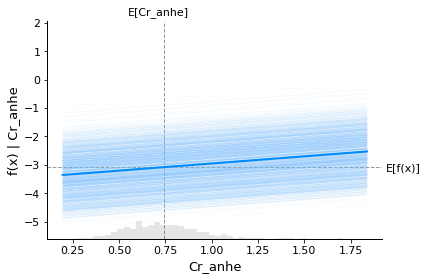

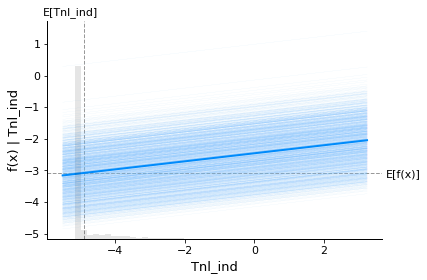

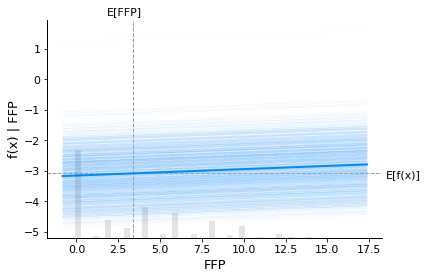

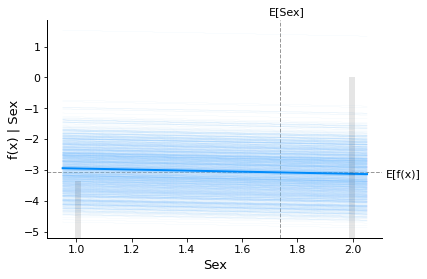

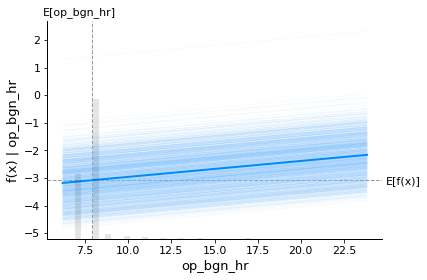

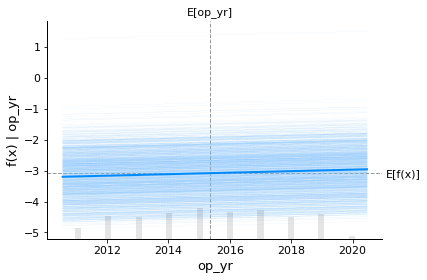

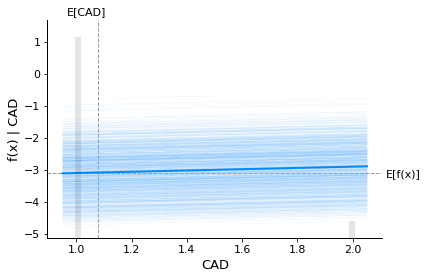

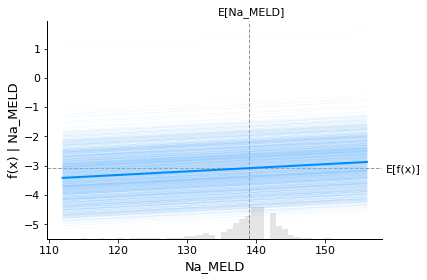

In [108]:
for i, col in enumerate(top10_columns):
    shap.partial_dependence_plot(col, vr.predict, df, 
                                 model_expected_value=True, feature_expected_value=True)